# Astronomy 8824 - Numerical and Statistical Methods in Astrophysics

## Numerical Methods Topic II. Ordinary Differential Equations

These notes are for the course Astronomy 8824: Numerical and Statistical Methods in Astrophysics. It is based on notes from David Weinberg with modifications and additions by Paul Martini.
David's original notes are available from his website: http://www.astronomy.ohio-state.edu/~dhw/A8824/index.html

#### Background reading: 
- Numerical Recipes, Chapter 16 (ODEs, first three sections) 
- Numerical Recipes, Chapter 17 (2-pt BV problems, first few sections)
- Binney & Tremaine, Galactic Dynamics, section on orbital integration

In [1]:
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import integrate

# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

### Introduction

Lots of problems in astronomy require solving an ODE. These include:
- orbits
- radiative transport
- hydrostatic equation in atmospheres
- stellar structure
- ...

Partial differential equations are also very common, such as the wave equation, the diffusion equation, Poissons equation. Those aren't covered here, but NR Chapter 19 is a good introduction. 

ODEs can be of any order. The first step in solving them is to simplify them into a system of first order ODEs. For example:

$$
{d^2y \over dx^2} + q(x){dy\over dx} = r(x)
$$
can be rewritten as
$$\eqalign{
{dy \over dx} &= z(x) \cr
{dz \over dx} &= r(x)-q(x)z(x),
}
$$
two first-order equations that can be integrated simultaneously.

The generic problem to solve is therefore a system of coupled first-order ODEs,

$$
{dy_i(x) \over dx} = f_i(x,y_1,y_2,...,y_N), \qquad i=1,...,N~.
$$

For the case of an orbit in a gravitational potential we have

$$
{d^2{\vec x} \over dt^2} = -\vec \nabla \Phi(\vec x)
$$
which can be written
$$\eqalign{
{d{\vec x} \over dt} &= \vec v \cr
{d{\vec v} \over dt} &= -\vec \nabla \Phi(\vec x)~.
}
$$

This can be written in the $dy_i(x)/dx$ form above, though for orbits it is most straightforward to just think in terms of $\vec x$ and $\vec v$.


Equations alone are not sufficient to specify an ODE problem -- you need boundary conditions too. These take the form of algebraic conditions and come in two categories: 
- Initial Value Problems: all $y_i$ are given at the starting $x$ values and the goal is to find the $y_i$ values at the final $x$ values (and/or at intermediate points). For example, one might specify $\vec x$ and $\vec v$ at $t=0$ and integrate forward in time.
- Two Point Boundary Value Problems: Boundary conditions specified at mulitple values of $x$.

### Initial Value Problems

The basic idea is to turn $dy_i$ and $dx$ into step sizes $\Delta y_i$ and $\Delta x$ and multiply the steps by $\Delta y$. In the limit of small stepsize for the independent variable $x$, one obtains a good approximation to the underlying DE. 

Doing exactly this is Euler's Method, and is not a good idea. As with numerical integration, a little more complexity produces much better return. 

There are three major types of methods:

1. Runge Kutta: propagate the solution over an interval by combining information from several "Euler-like" steps, then use the info to match a Taylor expansion up to some higher order.
2. Richardson Extrapolation: extrapolates a result to the one you would have obtained if you'd used a much smaller stepsize (or zero). These are often called Bulirsch-Stoer methods, and are analogous to Romberg Integration. This often works best, but like with Romberg integration, it works best if the function is smooth. 
3. Predictor-Corrector: These store information and use them to extrapolate a step ahead, then correct based on the derivative at the new point. These work best for very smooth functions, and are generally more efficient, but are harder to set up. 

### Side Note on Systems of Equations

Reference: Numerical Recipes, chapter 2.

The system of equations
$$\eqalign{
a_{11}x_1 + a_{12}x_2 + a_{13}x_3 + ... a_{1n}x_n &= b_1 \cr
a_{21}x_1 + a_{22}x_2 + a_{23}x_3 + ... a_{2n}x_n &= b_2 \cr
.... \cr
a_{n1}x_1 + a_{n2}x_2 + a_{n3}x_3 + ... a_{nn}x_n &= b_n \cr
}
$$
can be written in matrix form
$$
{\bf A} \cdot {\bf x} = {\bf b}.
$$

If the equations are linearly independent, then the matrix **A** is non-singular and invertible.

The solution to the equations is:
$$
{\bf x} = {\bf A^{-1}} \cdot {\bf A} \cdot {\bf x} = {\bf A^{-1}} \cdot {\bf b}.
$$

The computational task of matrix inversion is discussed in Chapter 2 of NR.

For small, non-singular matrices it is straightforward, allowing a
straightforward solution to a system of equations.

In [6]:
a=np.array([[1,9,7],[2,4,12],[3,7,3]])

print("Matrix a")
print(a)

b=np.array([9,-3,7])

ainv=np.linalg.inv(a)

print("Inverse of a")
print(ainv)

print("A x A-1")
print(np.dot(a,ainv))

x=np.dot(ainv,b)

print("A.x, which should equal b")
print(np.dot(a,x))

# And note this equals b

Matrix a
[[ 1  9  7]
 [ 2  4 12]
 [ 3  7  3]]
Inverse of a
[[-0.33962264  0.10377358  0.37735849]
 [ 0.14150943 -0.08490566  0.00943396]
 [ 0.00943396  0.09433962 -0.06603774]]
A x A-1
[[ 1.00000000e+00 -2.77555756e-17  1.38777878e-17]
 [-2.08166817e-17  1.00000000e+00 -5.55111512e-17]
 [-5.20417043e-18 -2.77555756e-17  1.00000000e+00]]
A.x, which should equal b
[ 9. -3.  7.]


The problem becomes more challenging when

- The solutions have to be done many, many times, in which case it's important to be efficient.

- The equations are degenerate or nearly so, in which case one needs _singular value decomposition_.

- The number of matrix elements is very large.  (If many of the matrix elements are zero, then one can use _sparse matrix methods_.)

There are many tools in python for linear algebra. A good place to start is scipy.linalg. While there is also numpy.linalg, the scipy version is guaranteed to be compiled with the latest LAPack libraries. 

### Runge-Kutta

We'll now think about integrating a single ODE for variable $y(x)$.

The simplest way to integrate an ODE, like the simplest way to do
a numerical integral, is Euler's method:

$$
y_{n+1} = y_n + hf(x_n,y_n) + \cal O(h^2)
$$

to advance from $x_n$ to $x_{n+1}=x_n+h$.

As with numerical integrals, this is a bad method; one can get
higher accuracy and greater stability with only slightly more work.

#### Mid-point method (2nd order Runge-Kutta)

This method uses the derivative at $x_n$ to advance to $x_{n+1/2}$. Then uses the derivative at $x_{n+1/2}$ to advance from $x_n$ to $x_{n+1}$.

$$\eqalign{
k_1 &= h f(x_n,y_n) \cr
k_2 &= hf(x_n+h/2,y_n+k_1/2) \cr
y_{n+1} &= y_n + k_2 + \cal O(h^3) 
}
$$

Since the number of steps is $\propto 1/h$, the error in the
integration should scale as $h^2$.

#### 4th order Runge-Kutta

One can evaluate at more intermediate points and fit a higher
order function.

This involves more evaluations per step, but it should allow
one to take larger steps.

The most commonly used scheme is 4th order, which seems to be
a good compromise between these two:
$$\eqalign{
k_1 &= h f(x_n,y_n) \cr
k_2 &= hf(x_n+h/2,y_n+k_1/2) \cr
k_3 &= hf(x_n+h/2,y_n+k_2/2) \cr
k_4 &= hf(x_n+h,y_n+k_3) \cr
y_{n+1} &= y_n + k_1/6 + k_2/3 + k_3/3 + k_4/6 + {\cal O}(h^5)~.
}
$$
This is a good workhorse routine. It is almost always better than the Midpoint Method. And can be especially good with an adaptive stepsize. Still, there are problems where Bulirsch-Stoer or Predictor-Corrector Methods are much better, especially for high accuracy. 

### Adaptive Step Size

If computing time is not an issue, you can just integrate your ODE multiple times with steadily decreasing $h$ and check for convergence to your desired accuracy.

However, the step size required for an accurate integration may vary by a large factor through the domain.

For example, integrating a highly elliptical orbit requires much smaller timesteps near
pericenter than through most of the orbit, so using a fixed timestep may be wasteful. And you would also like your code to give you an estimate of the accuracy of its answer.

The most straightforward idea is to advance from $x$ to $x+H$, where $H$ is macroscopic jump, using small steps $h$. Keep halving $h$ (doubling the number of steps) until the desired accuracy is achieved.

This approach is quite general.

For a specific problem, you may have physical intuition about what should guide the size of steps.

For example, the accuracy of integration may depend on the ratio of the timestep to the local dynamical time $(G\rho)^{-1/2}$ for a gravitational calculation, or sound-crossing time $L/c_s$ for a hydrodynamic calculation.

In such situations, you may be able to choose a constant scaling factor that multiplies some function of local conditions, rather than using step-doubling or other Runge-Kutta strategies.


For 4th order Runge Kutta, the basic idea is:
- Take a full step $2h = y_1$. 
- Take two half steps $h = y_2$. 
These three RK evaluations with 4 function evaluations each share a starting point, so it requires 11 function evaluations. Compared to just two half steps, you do 11/8 = 1.38 times more work. 

What is the advantage? You get an estimate of the truncation error: $\Delta = y_2 - y_1$. You can then adjust $h$ so the truncation error corresponds to the desired level of accuracy. 

### Bulirsch-Stoer

This is analogous to Romberg integration for numerical integrals.

The basic idea is to take a sequence of a different numbers of steps, with decreasing $h$. Then use the results for this sequence to extrapolate to the result for $h=0$.

NR is enthusiastic about this method for cases that require greater efficiency or higher accuracy than Runge-Kutta.

However, it's more susceptible to problems if the integration isn't smooth everywhere.

### Leapfrog Integration


Leapfrog is a 2nd-order integration scheme for gravitational problems.

The basic idea is to start from initial conditions $\vec x_0$, $\vec v_0$, and then take a half-step to get $\vec v_{1/2} = \vec v_0 - \half \vec \nabla \Phi(x_0) \Delta t$. For the next step, "leapfrog" the positions over the velocities, then the velocities over the positions, and so forth. That is: 

$$\eqalign{
\vec x_1 &= \vec x_0 + \vec v_{1/2}\Delta t \cr
\vec v_{3/2} &= \vec v_{1/2} -\nabla\Phi(\vec x_1)\Delta t \cr
\vec x_2 &= \vec x_1 + \vec v_{3/2}\Delta t \cr
{\rm etc.}
}
$$

Part of the second problem set involves the implementation of this method. 

I am almost sure that this is equivalent to 2nd-order Runge-Kutta but for the specific case of equations where $\dot{x}$ depends only on $v$ and $\dot{v}$ depends only on $x$, which makes it possible to do fewer evaluations.

_Important_: You will usually want to output both positions and velocities.  If your arrays store positions on the whole steps and velocities on the half-steps, then you must advance the velocities half-a-step before output (but be careful to get them back on the half-step before continuing the integration).  You also need to synchronize positions and velocities before computing energy conservation checks.


### Stiff Equations and Implicit Integration

Sometimes you want to integrate a system where there are two or more very different timescales.

If you integrate with timesteps short compared to the shorter timescale, your calculation may never finish.

A common example is a hydrodynamic system with cooling. In such a case one is typically interested in phenomena happening on the sound-crossing timescale $L/c_s$, where $L$ is the scale of the system. But in a dense region, the cooling timescale may become orders-of-magnitude shorter than the sound-crossing timescale.

If you have to do the short timescale integration accurately to get the long timescale behavior to be accurate, then you're stuck. But sometimes the short timescale behavior doesn't matter too much (e.g., it matters that the gas gets cold, but it doesn't matter exactly
what its temperature is), and you just need your integration to be stable.

In this case, an implicit scheme for the short timescale behavior may be useful.  Here is an example from NR:

$$
u' = 998 u + 1998 v 
$$
$$
v' = -999 u - 1999 v
$$
and use $u = 2y - z, v = -y + z$. Then you would get:
$$
y = 2 {\rm e}^{-x} - {\rm e}^{-1000x}
$$
$$
v = - {\rm e}^{x} + {\rm e}^{-1000x} 
$$
Sampling the ${\rm e}^{-1000x}$ terms requires a very smal step size, even though they may a negligible contribution to the value of $u, v$ far from the origin. 

Here is one way to 'fix' this. Consider: 

$$
y' = -cy ~, c>0~.
$$
so this means $y = {\rm e}^{-cx}$ and $y' = - c {\rm e}^{-cx} = -cy$. The explicit Euler scheme is

$$
y_{n+1} = y_n + hy'_n = (1-ch)y_n~.
$$

If $h > 2/c$, then the method is unstable, with $|y_n| \rightarrow \infty$ as $n \rightarrow \infty$. That is: 
$$ 
y_{n+1} = -(1 + \epsilon) y_n
$$

One can avoid this behavior by substituting $y'_{n+1}$ for $y'_n$, obtaining the implicit equation
$$
y_{n+1} = y_n + h y'_{n+1}.
$$

In this particular case, the implicit equation is trivially solved

$$
y_{n+1} = {y_n \over 1+ch}~,
$$

which gives a stable result - as $h \rightarrow \infty$, $y_{n+1} \rightarrow 0$.

More generally, the implicit equations may be solved by matrix inversion (if they're linear) or by some form of iteration (which we'll get to soon) if they're non-linear.

If you have a stiff set of equations, then sometimes the physics of the problem will suggest an alternative solution.

For example, when timescales for ionization are short compared to other timescales in the system, then relative abundances may always be close to ionization equilibrium, where recombination rates balance ionization rates.

This gives a set of equations that can be solved as a function of local conditions (e.g., density, temperature), and perhaps stored in a lookup table.

If you're interested in evolution of a hierarchical triple star system where the outer orbital period is much longer than the inner orbital period, it may be adequate to treat the inner binary as a ring with mass spread over the orbit according to the amount of time the stars spend there.


### Two Point Boundary Value Problems

Sometimes your boundary conditions aren't all specified at the same point.

For example, you might know an initial position but be trying to achieve
a specific final velocity.

Stellar structure is a classic example: some boundary conditions are
known at the center of the star, but others are known at the surface.

Two general strategies for this kind of problem are 
the _shooting method_ and _relaxation methods_.

In the simplest version of the shooting method, you take a guess at the initial boundary values and see where you end up. Then you change an initial boundary value and see how that changes where you end up. You can now do some form of iteration (as will be discussed in two weeks) to try to zero in on the correct initial boundary condition to satisfy your final boundary condition.

It's like firing your artillery shell and continuously adjusting the angle of your gun until you hit your desired target. 


Sometimes it may be very difficult to get to the right final boundary condition.

In such cases it may be better to integrate from both sides and try to meet in the middle, e.g., from the center of the star and the surface of the star.

In relaxation methods, you start with an approximate guess at the full solution.  

You then use finite differences to calculate the errors in this guess at every point in the domain.

You then try to adjust your solution to eliminate these errors. If your guess is close, then you may be able to reduce the problem of eliminating the errors to a problem of solving simultaneous linear equations.

Relaxation methods are most useful when you have a very good guess to start with.

For example, you may want to solve for a sequence of main sequence stellar models with increasing mass.  The solution at mass $M$, perhaps scaled in some way, then becomes a good starting guess for the solution at mass $M+\epsilon$.

One could do the evolution of a star of fixed $M$ in a similar way, with the composition changing slightly from one time to the next.


### Python Routines

In [3]:
## Harmonic Oscillator Example

def ho(xi, t, k, m):
    x = xi[0]
    v = xi[1]
    dxdt = v
    dvdt = - (k/m) * x
    return [dxdt, dvdt]

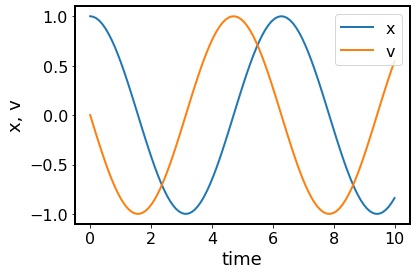

In [4]:
xi = [1, 0]
t = np.linspace(0, 10, 100)
k = 2
m = 2
yi = integrate.odeint(ho, xi, t, args=(k,m))

plt.plot(t, yi[:,0], label="x")
plt.plot(t, yi[:,1], label="v")
plt.xlabel("time")
plt.ylabel("x, v")
plt.legend()